# **Movie Recommendation System**

**🎯Dataset Goal & Source**<br>
The goal of these datasets is to analyze user–movie interactions to understand viewing preferences and rating behaviors. It is primarily used for building movie recommendation systems.

These dataset supports multiple machine learning tasks:

Regression: Predicting user ratings for unseen movies.

Clustering: Grouping users or movies based on similarities.

📦 Source:
The datasets were obtained from Kaggle,
[Dataset Link](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data?select=movies_metadata.csv)

**Movies Dataset Feature description**<br>
* adult: Indicates if the movie is rated as adult content (True/False).

* belongs_to_collection: Shows if the movie is part of a collection or franchise.

* budget: Production budget of the movie in USD.

* genres: List of genres the movie belongs to (e.g., Action, Drama).

* homepage: URL of the movie’s official website.

* id: Unique identifier for the movie in the dataset.

* imdb_id: Unique identifier for the movie on IMDb.

* original_language: Language in which the movie was originally produced.

* original_title: Original title of the movie.

* overview: Brief textual description or synopsis of the movie.

* popularity: Popularity score (usually from TMDb) representing general audience interest.

* poster_path: File path or URL of the movie’s poster image.

* production_companies: List of companies that produced the movie.

* production_countries: List of countries where the movie was produced.

* release_date: Official release date of the movie.

* revenue: Total revenue generated by the movie in USD.

* runtime: Duration of the movie in minutes.

* spoken_languages: Languages spoken in the movie.

* status: Current status of the movie (e.g., Released, Post Production).

* tagline: Short tagline or slogan for the movie.

* title: Official title of the movie.

* video: Boolean indicating if a video file is associated with the movie.

* vote_average: Average user rating for the movie (usually scale 0–10).

* vote_count: Total number of votes cast by users for the movie.



**User Rating Dataset Feature Description**<br>

* **userId**: Unique identifier for each user who rated movies.
* **Id**: Unique identifier for each movie being rated.
* **rating**: Score given by the user to the movie, on a scale from 1 to 5.
* **timestamp**: Time when the rating was submitted

## **1. Import Libraries**

In [60]:
from google.colab import drive
from IPython.display import HTML, display
import pandas as pd #for processing data
import numpy as np #Numerical computations and Encoding
import matplotlib.pyplot as plt #for Visualisation
import seaborn as sns #for Visualisation

## **2. Load Datasets**

###2.1 🎬 Load Movies Dataset
Load metadata (titles, genres, production info, etc.).

In [61]:
drive.mount('/content/drive')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
df = pd.read_csv('/content/drive/MyDrive/Movie_Recommendation/movies_metadata.csv', low_memory=False)
movies = pd.read_csv('/content/drive/MyDrive/Movie_Recommendation/movies_metadata.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3661195394.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('/content/drive/MyDrive/Movie_Recommendation/movies_metadata.csv')


###2.2 ⭐ Load User Ratings Dataset

Load user ratings (userId, movieId, rating, timestamp).

In [62]:
user_rating = pd.read_csv("/content/drive/MyDrive/Movie_Recommendation/ratings.csv") #load the dataset

## **3. Exploratory Data Analysis (EDA)**

###3.1 Movies Dataset

#### 3.1.1 General information
Shape, data types, and basic statistics.

In [63]:
# @title
n_rows = df.shape[0]
n_cols = df.shape[1]
dataset_size = df.memory_usage(deep=True).sum() / (1024**2)

display(HTML(f"""
<h3>1. General Information</h3>
<h4>Dataset Overview</h4>
<p>
Number of Observations (Rows): {n_rows:,} movies<br>
Number of Features (Columns): {n_cols} features<br>
Dataset Size: {dataset_size:.1f} MB in memory
</p>
"""))

In [123]:
# -----------------------------
# 1️⃣ Convert mostly-numeric object columns
# -----------------------------
for col in df.columns:
    if df[col].dtype == 'object':
        converted = pd.to_numeric(df[col], errors='coerce')
        # If more than 10% values are numeric, convert
        if converted.notna().sum() > len(df) * 0.1:
            df[col] = converted

# -----------------------------
# 2️⃣ Select numerical and categorical features (exclude 'rating_category')
# -----------------------------
numerical_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                      if 'rating_category' not in col]
categorical_features = [col for col in df.select_dtypes(include=['object']).columns
                        if 'rating_category' not in col]

# Ensure 'video' is considered categorical if originally numeric
if 'video' in numerical_features:
    numerical_features.remove('video')
    categorical_features.append('video')

# -----------------------------
# 3️⃣ Prepare display column list (exclude 'rating_category')
# -----------------------------
display_columns = [col for col in df.columns if 'rating_category' not in col]

# -----------------------------
# 4️⃣ Summary stats for vote_average (informative only)
# -----------------------------
vote_var = 'vote_average'
vote_mean = df[vote_var].mean()
vote_std = df[vote_var].std()
vote_min = df[vote_var].min()
vote_max = df[vote_var].max()
vote_median = df[vote_var].median()

# -----------------------------
# 5️⃣ Display General Information
# -----------------------------
from IPython.display import display, HTML

display(HTML(f"""
<h4>Features Overview</h4>
<p>The dataset contains {len(display_columns)} features:</p>
<p>{', '.join(display_columns)}</p>

<h4>Data Types</h4>
<p>Numerical Features ({len(numerical_features)}): {', '.join(numerical_features)}</p>
<p>Categorical Features ({len(categorical_features)}): {', '.join(categorical_features)}</p>

<h4>Vote Average Summary (Informative)</h4>
<p><b>{vote_var}</b> - Average user rating for each movie (scale: 0-10)</p>
<ul>
  <li>Mean: {vote_mean:.2f}</li>
  <li>Standard Deviation: {vote_std:.2f}</li>
  <li>Range: {vote_min:.1f} to {vote_max:.1f}</li>
  <li>Median: {vote_median:.1f}</li>
</ul>
<p>Note: <b>{vote_var}</b> is retained for exploratory and clustering analyses, not as a supervised target.</p>
"""))


In [65]:
# @title
# Select numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude 'id' and 'video'
numerical_features = [col for col in numerical_features if col not in ['id', 'video']]

if len(numerical_features) > 0:
    stats_data = []
    for col in numerical_features[:6]:  # first 6 numeric features
        mean_val = df[col].mean()
        std_val = df[col].std()
        min_val = df[col].min()
        max_val = df[col].max()

        # Format mean
        if mean_val > 1e9:
            mean_str = f"${mean_val/1e9:.2f}B"
        elif mean_val > 1e6:
            mean_str = f"${mean_val/1e6:.1f}M"
        else:
            mean_str = f"{mean_val:.1f}"

        # Format std
        if std_val > 1e9:
            std_str = f"${std_val/1e9:.2f}B"
        elif std_val > 1e6:
            std_str = f"${std_val/1e6:.1f}M"
        else:
            std_str = f"{std_val:.1f}"

        # Format max
        if max_val > 1e9:
            max_str = f"${max_val/1e9:.2f}B"
        elif max_val > 1e6:
            max_str = f"${max_val/1e6:.1f}M"
        else:
            max_str = f"{max_val:.0f}"

        stats_data.append({
            'col': col,
            'mean': mean_str,
            'std': std_str,
            'min': round(min_val, 4),
            'max': max_str
        })

    # Build table rows
    table_rows = ""
    for stat in stats_data:
        table_rows += f"""
  <tr>
    <td>{stat['col']}</td>
    <td>{stat['mean']}</td>
    <td>{stat['std']}</td>
    <td>{stat['min']}</td>
    <td>{stat['max']}</td>
  </tr>
"""

    display(HTML(f"""
<h3>2. Summary & Visualization</h3>
<h4>2.1 Statistical Summary</h4>

<table border="1" style="border-collapse: collapse; width: 100%;">
  <tr style="background-color: #4CAF50; color: white;">
    <th>Feature</th>
    <th>Mean</th>
    <th>Std Dev</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
{table_rows}
</table>
"""))


Feature,Mean,Std Dev,Min,Max
budget,$4.2M,$17.4M,0.0,$380.0M
popularity,2.9,6.0,0.0,547
revenue,$11.2M,$64.3M,0.0,$2.79B
runtime,94.1,38.4,0.0,1256
vote_average,5.6,1.9,0.0,10
vote_count,109.9,491.3,0.0,14075


In [66]:
# @title
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

observations = []
for col in numerical_features[:4]:
    median_val = df[col].median()
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    mean_val = df[col].mean()

    if median_val == 0 or median_val < mean_val * 0.1:
        observations.append(f"{col.capitalize()} is highly skewed (median = {median_val:.0f})")
    elif q25 > 0 and q75 > 0:
        observations.append(f"Most values for {col} are between {q25:.0f}-{q75:.0f}")

cat_observations = []
for col in categorical_features[:3]:
    if df[col].notna().sum() > 0:
        top_val = df[col].value_counts().index[0]
        top_count = df[col].value_counts().iloc[0]
        top_pct = (top_count / len(df)) * 100
        cat_observations.append(f"Most Common {col.replace('_', ' ').title()}: {top_val} ({top_count:,} - {top_pct:.1f}%)")

obs_html = "".join([f"<li>{obs}</li>" for obs in observations[:4]])
cat_html = "".join([f"<li>{obs}</li>" for obs in cat_observations[:3]])

display(HTML(f"""
<h5>Key Observations:</h5>
<ul>
{obs_html}
</ul>

<h5>Categorical Features:</h5>
<ul>
{cat_html}
</ul>
"""))

print("\nNumerical Features Summary:")
print(df[numerical_features].describe())


Numerical Features Summary:
             budget             id    popularity       revenue       runtime  \
count  4.546300e+04   45463.000000  45460.000000  4.546000e+04  45203.000000   
mean   4.224579e+06  108359.918813      2.921478  1.120935e+07     94.128199   
std    1.742413e+07  112460.749278      6.005414  6.433225e+07     38.407810   
min    0.000000e+00       2.000000      0.000000  0.000000e+00      0.000000   
25%    0.000000e+00   26449.500000      0.385948  0.000000e+00     85.000000   
50%    0.000000e+00   60003.000000      1.127685  0.000000e+00     95.000000   
75%    0.000000e+00  157328.000000      3.678902  0.000000e+00    107.000000   
max    3.800000e+08  469172.000000    547.488298  2.787965e+09   1256.000000   

              video  vote_average    vote_count  
count  45460.000000  45460.000000  45460.000000  
mean       0.002046      5.618207    109.897338  
std        0.045184      1.924216    491.310374  
min        0.000000      0.000000      0.000000  


In [67]:
# @title
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

table_rows = ""
for idx, row in missing_df.head(10).iterrows():
    if row['Missing_Percentage'] > 80:
        bg_color = "#ffebee"
        severity = "🔴 Critical"
    elif row['Missing_Percentage'] > 50:
        bg_color = "#fff9c4"
        severity = "🟡 Moderate"
    elif row['Missing_Percentage'] > 1:
        bg_color = "#e8f5e9"
        severity = "🟢 Minor"
    else:
        bg_color = "#f1f8e9"
        severity = "🟢 Minimal"

    table_rows += f"""
  <tr style="background-color: {bg_color}; color: black;">
    <td>{row['Column']}</td>
    <td>{row['Missing_Count']:,.0f}</td>
    <td>{row['Missing_Percentage']:.1f}%</td>
    <td>{severity}</td>
  </tr>
"""

display(HTML(f"""
<h4>2.2 Missing Value Analysis</h4>

<table border="1" style="border-collapse: collapse; width: 100%; color: black;">
  <tr style="background-color: #4CAF50; color: white;">
    <th>Feature</th>
    <th>Missing Count</th>
    <th>Missing %</th>
    <th>Severity</th>
  </tr>
{table_rows}
</table>
"""))

print("\nMissing Values Summary:")
print(missing_df)

Feature,Missing Count,Missing %,Severity
belongs_to_collection,"40,972",90.1%,🔴 Critical
homepage,"37,684",82.9%,🔴 Critical
tagline,"25,054",55.1%,🟡 Moderate
overview,954,2.1%,🟢 Minor
poster_path,386,0.8%,🟢 Minimal
runtime,263,0.6%,🟢 Minimal
release_date,87,0.2%,🟢 Minimal
status,87,0.2%,🟢 Minimal
imdb_id,17,0.0%,🟢 Minimal
original_language,11,0.0%,🟢 Minimal



Missing Values Summary:
                   Column  Missing_Count  Missing_Percentage
1   belongs_to_collection          40972           90.115691
4                homepage          37684           82.883913
19                tagline          25054           55.104914
9                overview            954            2.098271
11            poster_path            386            0.848986
16                runtime            263            0.578454
14           release_date             87            0.191352
18                 status             87            0.191352
6                 imdb_id             17            0.037391
7       original_language             11            0.024194
21                  video              6            0.013197
20                  title              6            0.013197
10             popularity              6            0.013197
22           vote_average              6            0.013197
23             vote_count              6            0.013197

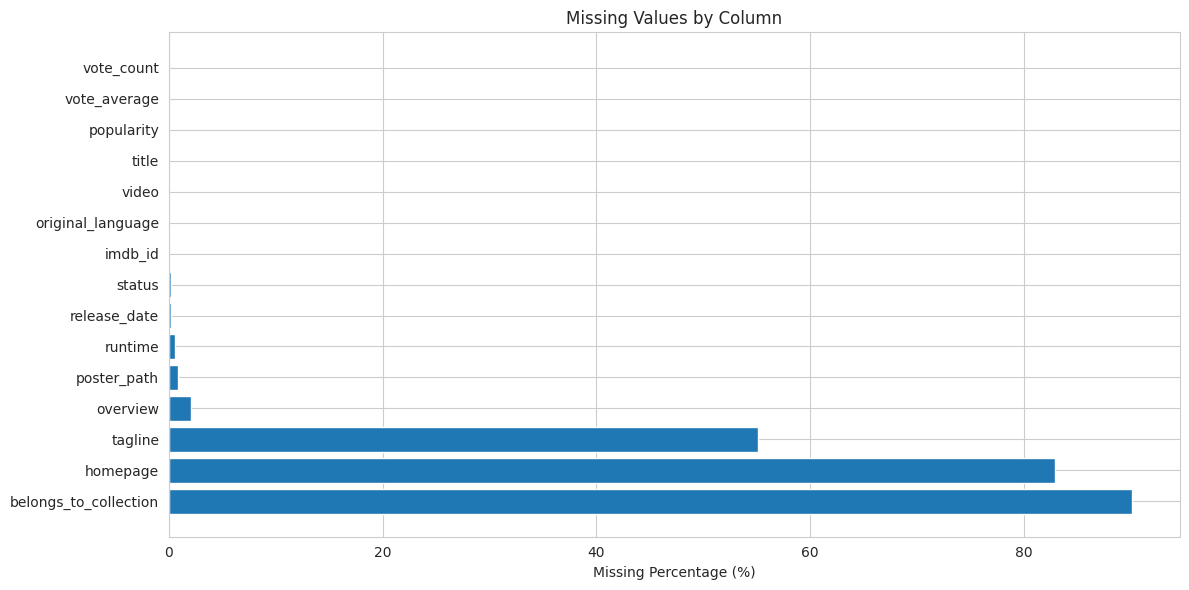

In [68]:
# @title
if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(missing_df['Column'].head(15), missing_df['Missing_Percentage'].head(15))
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.savefig('missing_values.png')
    plt.show()

    display(HTML("<p><b>Figure 1: Missing Values by Feature</b></p>"))

critical_cols = missing_df[missing_df['Missing_Percentage'] > 80]['Column'].tolist()
moderate_cols = missing_df[(missing_df['Missing_Percentage'] > 50) & (missing_df['Missing_Percentage'] <= 80)]['Column'].tolist()
minor_cols = missing_df[missing_df['Missing_Percentage'] <= 3]['Column'].tolist()

display(HTML(f"""
<h5>Impact Assessment:</h5>
<ul>
  <li><b>High Impact:</b> {', '.join(critical_cols[:3])} are mostly missing but may not be critical for analysis</li>
  <li><b>Moderate Impact:</b> {', '.join(moderate_cols[:2])} missing could affect certain analyses</li>
  <li><b>Low Impact:</b> Core features have &lt; 3% missing data</li>
</ul>
<p><b>Recommendation:</b> Imputation or removal strategies needed for high-missing features depending on analysis goals.</p>
"""))

In [69]:
# @title
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

dist_descriptions = []
for col in numerical_features[:4]:
    data = df[col].dropna()
    skewness = data.skew()
    mean_val = data.mean()
    median_val = data.median()
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)

    if abs(skewness) < 0.5:
        shape = "Approximately normal"
    elif skewness > 0.5:
        shape = "Right-skewed"
    else:
        shape = "Left-skewed"

    dist_descriptions.append(f"""
<h5>{col.replace('_', ' ').title()} Distribution:</h5>
<ul>
  <li><b>Shape:</b> {shape}</li>
  <li><b>Central Tendency:</b> Mean = {mean_val:.1f}, Median = {median_val:.1f}</li>
  <li><b>Range:</b> {data.min():.1f} to {data.max():.1f}</li>
  <li><b>IQR:</b> {q25:.1f} to {q75:.1f}</li>
</ul>
""")

display(HTML(f"""
<h4>2.3 Variable Distributions</h4>
{''.join(dist_descriptions)}
"""))

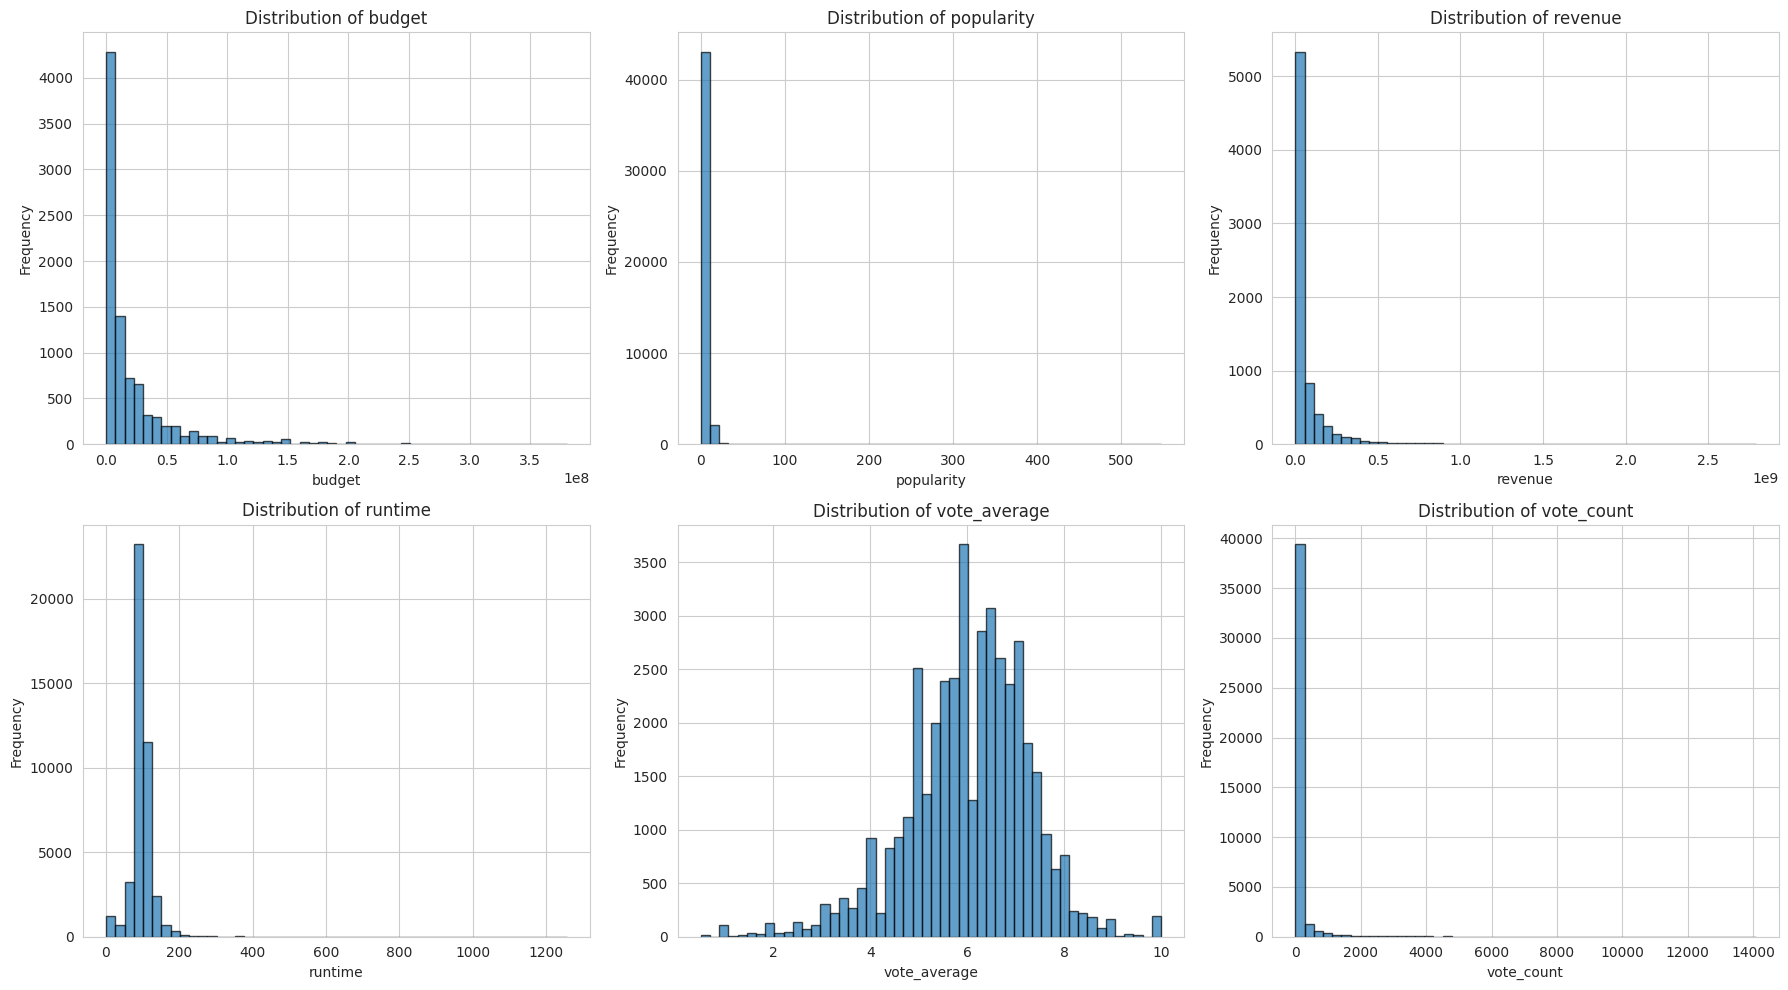

In [70]:
# @title
# Select numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude 'id' (and 'video' if you want)
numerical_features = [col for col in numerical_features if col not in ['id', 'video']]

# Number of columns and rows for subplots
n_cols = min(len(numerical_features), 6)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows*5))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col in enumerate(numerical_features[:n_cols]):
    data = df[col].dropna()
    # Use only positive values if min >= 0
    data = data[data > 0] if data.min() >= 0 else data

    if len(data) > 0:
        axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

# Turn off unused axes
for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('distributions.png')
plt.show()

display(HTML("<p><b>Figure 2: Distribution of Numerical Features</b></p>"))


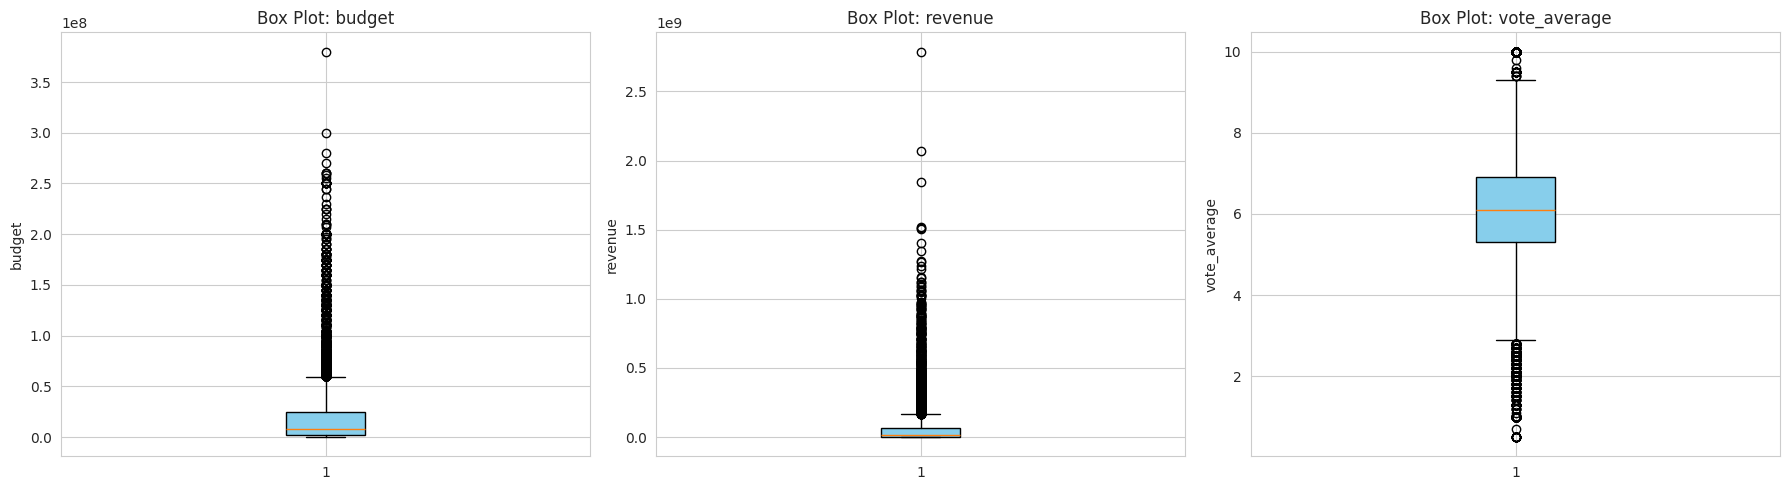

In [71]:
# @title 📊 Box Plots for Outlier Detection (Safe Numeric Conversion)
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import pandas as pd

# Columns to plot
numeric_cols = ['budget', 'revenue', 'vote_average']

# Convert to numeric safely
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # turn non-numeric to NaN

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numeric_cols):
    data = df[col].dropna()
    data = data[data > 0]  # remove zeros if invalid
    axes[idx].boxplot(data, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axes[idx].set_title(f'Box Plot: {col}', fontsize=12)
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.savefig('boxplots.png', bbox_inches='tight')
plt.show()

display(HTML("<p><b>Figure 3: Box Plots for Outlier Detection</b></p>"))


In [72]:
# @title
df['rating_category'] = pd.cut(df['vote_average'],
                               bins=[0, 4, 6, 8, 10],
                               labels=['Poor', 'Average', 'Good', 'Excellent'])

category_counts = df['rating_category'].value_counts().sort_index()
total = category_counts.sum()

poor_count = category_counts.get('Poor', 0)
poor_pct = (poor_count / total) * 100
avg_count = category_counts.get('Average', 0)
avg_pct = (avg_count / total) * 100
good_count = category_counts.get('Good', 0)
good_pct = (good_count / total) * 100
excellent_count = category_counts.get('Excellent', 0)
excellent_pct = (excellent_count / total) * 100

display(HTML(f"""
<h4>2.4 Class Imbalance Analysis</h4>

<table border="1" style="border-collapse: collapse; width: 100%;">
  <tr style="background-color: #4CAF50; color: white;">
    <th>Category</th>
    <th>Range</th>
    <th>Count</th>
    <th>Percentage</th>
  </tr>
  <tr>
    <td>Poor</td>
    <td>0-4</td>
    <td>{poor_count:,}</td>
    <td>{poor_pct:.1f}%</td>
  </tr>
  <tr>
    <td>Average</td>
    <td>4-6</td>
    <td>{avg_count:,}</td>
    <td>{avg_pct:.1f}%</td>
  </tr>
  <tr >
    <td>Good</td>
    <td>6-8</td>
    <td>{good_count:,}</td>
    <td>{good_pct:.1f}%</td>
  </tr>
  <tr>
    <td>Excellent</td>
    <td>8-10</td>
    <td>{excellent_count:,}</td>
    <td>{excellent_pct:.1f}%</td>
  </tr>
</table>
"""))

print("\nRating Category Distribution:")
print(df['rating_category'].value_counts())

Category,Range,Count,Percentage
Poor,0-4,"3,037",7.2%
Average,4-6,"17,650",41.6%
Good,6-8,"20,645",48.6%
Excellent,8-10,"1,130",2.7%



Rating Category Distribution:
rating_category
Good         20645
Average      17650
Poor          3037
Excellent     1130
Name: count, dtype: int64


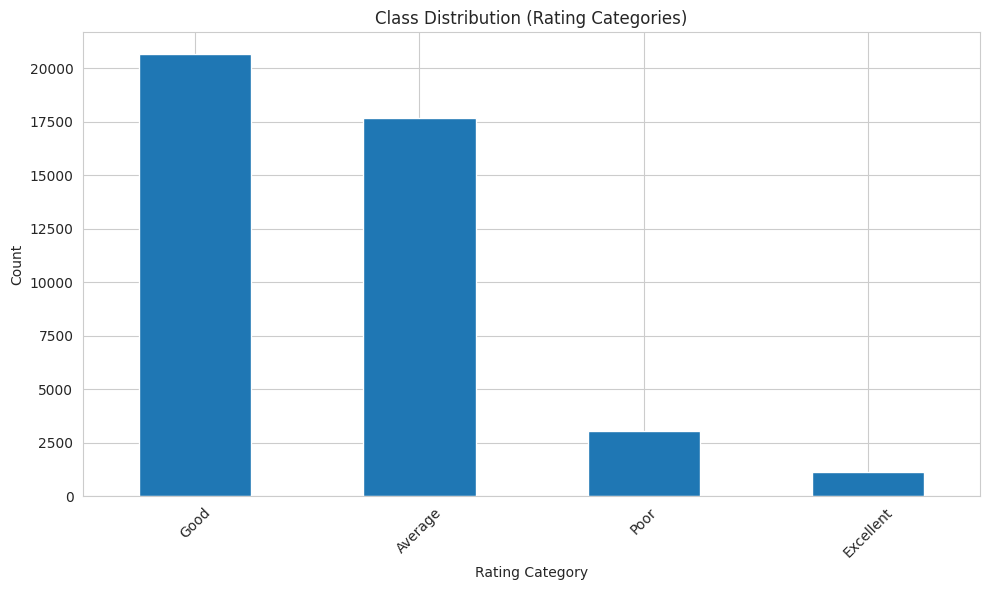

In [73]:
# @title
plt.figure(figsize=(10, 6))
df['rating_category'].value_counts().plot(kind='bar')
plt.title('Class Distribution (Rating Categories)')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_imbalance.png')
plt.show()

display(HTML("<p><b>Figure 4: Rating Category Distribution</b></p>"))

max_category = category_counts.idxmax()
max_pct = (category_counts.max() / total) * 100
min_category = category_counts.idxmin()
min_pct = (category_counts.min() / total) * 100

display(HTML(f"""
<h5>Imbalance Detected:</h5>
<ul>
  <li>Significant class imbalance exists</li>
  <li>"{max_category}" category is overrepresented ({max_pct:.1f}%)</li>
  <li>"{min_category}" category is underrepresented ({min_pct:.1f}%)</li>
  <li><b>Recommendation:</b> Consider using stratified sampling or class weighting for predictive modeling</li>
</ul>
"""))

####  3.1.2 Missing Values, Cleaning & Feature Engineering


In [74]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [75]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


**Drop unnecessary columns**<br>
Drop columns which are irrelevant to the task and doesn't provide useful information

In [76]:
cols_to_drop = ['homepage','status','poster_path','video','imdb_id','tagline']
movies.drop(columns=[c for c in cols_to_drop if c in movies.columns], inplace=True)

In [77]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   id                     45466 non-null  object 
 5   original_language      45455 non-null  object 
 6   original_title         45466 non-null  object 
 7   overview               44512 non-null  object 
 8   popularity             45461 non-null  object 
 9   production_companies   45463 non-null  object 
 10  production_countries   45463 non-null  object 
 11  release_date           45379 non-null  object 
 12  revenue                45460 non-null  float64
 13  runtime                45203 non-null  float64
 14  spoken_languages       45460 non-null  object 
 15  ti

**Replacing missing collection data with 'NO Collection', extracting the collection name from each entry**

In [78]:
movies.belongs_to_collection.fillna("{'name':'NO Collection'}", inplace=True)
movies.belongs_to_collection = movies.belongs_to_collection.apply(lambda x: eval(x))
movies.belongs_to_collection = movies.belongs_to_collection.apply(lambda x: x['name'] if isinstance(x, dict) else 'NO Collection')
movies.belongs_to_collection.head(20)

/tmp/ipython-input-387327683.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies.belongs_to_collection.fillna("{'name':'NO Collection'}", inplace=True)


,belongs_to_collection
0,Toy Story Collection
1,NO Collection
2,Grumpy Old Men Collection
3,NO Collection
4,Father of the Bride Collection
5,NO Collection
6,NO Collection
7,NO Collection
8,NO Collection
9,James Bond Collection


**This code calculates and summarizes (using .describe()) the number of genres listed for each movie in the genres column.**

In [79]:
movies.genres.apply(lambda x: len(eval(x)) if isinstance(x, str) else 0).describe()

,genres
count,45466.000000
mean,2.003827
std,1.131100
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,8.000000


**This code analyzes genre counts, extracts the first two genre names (or “NO Genre” if missing), replaces empty second genres with the first, drops the original genres column, and shows the first 20 rows.**

In [80]:
movies['genre1'] = movies.genres.apply(lambda x: eval(x)[0]['name'] if isinstance(x, str) and len(eval(x)) > 0 else 'NO Genre')
movies['genre2'] = movies.genres.apply(lambda x: eval(x)[1]['name'] if isinstance(x, str) and len(eval(x)) > 1 else 'NO Genre')
movies.loc[movies.genre2 == 'NO Genre', 'genre2'] = movies.loc[movies.genre2 == 'NO Genre', 'genre1']
movies.drop('genres', inplace=True, axis=1)
movies.head(20)

,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,genre1,genre2
0,False,Toy Story Collection,30000000,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,Animation,Comedy
1,False,NO Collection,65000000,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,Adventure,Fantasy
2,False,Grumpy Old Men Collection,0,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,Romance,Comedy
3,False,NO Collection,16000000,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,Comedy,Drama
4,False,Father of the Bride Collection,0,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,Comedy,Comedy
5,False,NO Collection,60000000,949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Heat,7.7,1886.0,Action,Crime
6,False,NO Collection,58000000,11860,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Sabrina,6.2,141.0,Comedy,Romance
7,False,NO Collection,0,45325,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",2.561161,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Tom and Huck,5.4,45.0,Action,Adventure
8,False,NO Collection,35000000,9091,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Sudden Death,5.5,174.0,Action,Adventure
9,False,James Bond Collection,58000000,710,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",GoldenEye,6.6,1194.0,Adventure,Action


In [81]:
movies.genre1.value_counts()

,count
genre1,
Drama,11966
Comedy,8820
Action,4489
Documentary,3415
Horror,2619
NO Genre,2442
Crime,1685
Thriller,1665
Adventure,1514


**Removing missing production data, extracting the first production company and country names, and displaying the first 10 movies.**

In [82]:
movies.dropna(subset=['production_companies','production_countries'], inplace=True)
movies['production_companies'] = movies['production_companies'].apply(eval)
movies['production_companies'] = movies['production_companies'].apply(lambda x: x[0]['name'] if isinstance(x, list) and x else None)
movies['production_countries'] = movies['production_countries'].apply(eval)
movies['production_countries'] = movies['production_countries'].apply(lambda x: x[0]['name'] if isinstance(x, list) and x else None)
movies.head(10)

,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,genre1,genre2
0,False,Toy Story Collection,30000000,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,Animation,Comedy
1,False,NO Collection,65000000,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,United States of America,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,Adventure,Fantasy
2,False,Grumpy Old Men Collection,0,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,Warner Bros.,United States of America,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,Romance,Comedy
3,False,NO Collection,16000000,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,Comedy,Drama
4,False,Father of the Bride Collection,0,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions,United States of America,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,Comedy,Comedy
5,False,NO Collection,60000000,949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency Enterprises,United States of America,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Heat,7.7,1886.0,Action,Crime
6,False,NO Collection,58000000,11860,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,Paramount Pictures,Germany,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Sabrina,6.2,141.0,Comedy,Romance
7,False,NO Collection,0,45325,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",2.561161,Walt Disney Pictures,United States of America,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Tom and Huck,5.4,45.0,Action,Adventure
8,False,NO Collection,35000000,9091,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,Universal Pictures,United States of America,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Sudden Death,5.5,174.0,Action,Adventure
9,False,James Bond Collection,58000000,710,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,United Artists,United Kingdom,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",GoldenEye,6.6,1194.0,Adventure,Action


In [83]:
movies.production_companies.value_counts()

,count
production_companies,
Paramount Pictures,998
Metro-Goldwyn-Mayer (MGM),852
Twentieth Century Fox Film Corporation,780
Warner Bros.,757
Universal Pictures,754
...,...
Kingsize Entertainment,1
Watchmaker Films,1
Social Capital,1


**Removing duplicate rows from the dataset, keeping only the first occurrence of each unique record.**


In [84]:
movies.drop_duplicates()

,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,genre1,genre2
0,False,Toy Story Collection,30000000,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,Animation,Comedy
1,False,NO Collection,65000000,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,United States of America,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,Adventure,Fantasy
2,False,Grumpy Old Men Collection,0,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,Warner Bros.,United States of America,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,Romance,Comedy
3,False,NO Collection,16000000,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,Comedy,Drama
4,False,Father of the Bride Collection,0,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions,United States of America,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,Comedy,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NO Collection,0,439050,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,None,Iran,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Subdue,4.0,1.0,Drama,Family
45462,False,NO Collection,0,111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,Sine Olivia,Philippines,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Century of Birthing,9.0,3.0,Drama,Drama
45463,False,NO Collection,0,67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,American World Pictures,United States of America,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Betrayal,3.8,6.0,Action,Drama
45464,False,NO Collection,0,227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,Yermoliev,Russia,1917-10-21,0.0,87.0,[],Satan Triumphant,0.0,0.0,NO Genre,NO Genre


**Removing rows with missing values in the production_companies ,production_countries and overview columns.**

In [85]:
movies.dropna(subset = ["production_companies","production_countries"],inplace = True)

In [86]:
movies.dropna(subset = ["overview"],inplace = True)

In [87]:
movies.dropna(subset = ["release_date","original_language"],inplace = True)

Justification and Exploration of the Weighted Rating Formula

The weighted rating formula is designed to provide a more reliable measure of a movie’s quality by accounting for both the average rating a movie receives and the number of votes it has accumulated.
This approach, originally popularized by IMDb for its Top 250 ranking system, avoids overvaluing movies that have very few votes but unusually high or low averages.

 Concept and Formula

IMDb’s method combines a movie’s individual rating with the overall average rating across all movies, using the following general formula:

$
WR = \left( \frac{v}{v + m} \right) \times R + \left( \frac{m}{v + m} \right) \times C
$

Where:  
- \( WR \): Weighted Rating  
- \( v \): Number of votes for the movie  
- \( R \): Average rating for the movie  
- \( m \): Minimum votes required for consideration  
- \( C \): Mean vote across all movies  

 Interpretation

This formula ensures a fairer comparison among movies by introducing a smoothing mechanism:

Movies with few votes (small v) are adjusted toward the overall mean (C), reducing the impact of potentially biased or extreme early ratings.

Movies with many votes (large v) rely more heavily on their actual average rating (R), reflecting broader audience consensus.

The parameter m acts as a balancing factor that determines how much weight the global mean carries for less-voted titles.

🔍 Exploration and Impact

When applied to the dataset, this formula produces a new feature — the weighted rating — that better captures both vote count and average vote.

In [88]:
# Mean rating
C = movies['vote_average'].mean()

# Smoothing factor (can use 80th percentile, median, etc.)
m = movies['vote_count'].quantile(0.50)

# Compute weighted rating for all movies
movies['weighted_rating'] = (
    (movies['vote_count'] / (movies['vote_count'] + m) * movies['vote_average'])
    + (m / (movies['vote_count'] + m) * C)
)

movies.head(10)


,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,genre1,genre2,weighted_rating
0,False,Toy Story Collection,30000000,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,Animation,Comedy,7.694816
1,False,NO Collection,65000000,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,United States of America,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,Adventure,Fantasy,6.893350
2,False,Grumpy Old Men Collection,0,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,Warner Bros.,United States of America,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,Romance,Comedy,6.405165
3,False,NO Collection,16000000,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,Comedy,Drama,6.015361
4,False,Father of the Bride Collection,0,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions,United States of America,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,Comedy,Comedy,5.709855
5,False,NO Collection,60000000,949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency Enterprises,United States of America,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Heat,7.7,1886.0,Action,Crime,7.685193
6,False,NO Collection,58000000,11860,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,Paramount Pictures,Germany,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Sabrina,6.2,141.0,Comedy,Romance,6.163799
7,False,NO Collection,0,45325,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",2.561161,Walt Disney Pictures,United States of America,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Tom and Huck,5.4,45.0,Action,Adventure,5.505878
8,False,NO Collection,35000000,9091,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,Universal Pictures,United States of America,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Sudden Death,5.5,174.0,Action,Adventure,5.525676
9,False,James Bond Collection,58000000,710,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,United Artists,United Kingdom,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",GoldenEye,6.6,1194.0,Adventure,Action,6.590366


**Extracting the release year for simplifying temporal analysis and allowing inclusion as a numeric feature for modeling.**

In [89]:
# Ensure release_date is string
movies['release_date'] = movies['release_date'].astype(str)

# Extract year (first 4 characters)
movies['release_year'] = movies['release_date'].str[:4].astype(int)
movies.head()


,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,title,vote_average,vote_count,genre1,genre2,weighted_rating,release_year
0,False,Toy Story Collection,30000000,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,Animation,Comedy,7.694816,1995
1,False,NO Collection,65000000,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures,United States of America,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,Adventure,Fantasy,6.893350,1995
2,False,Grumpy Old Men Collection,0,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,Warner Bros.,United States of America,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,Romance,Comedy,6.405165,1995
3,False,NO Collection,16000000,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,Comedy,Drama,6.015361,1995
4,False,Father of the Bride Collection,0,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions,United States of America,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,Comedy,Comedy,5.709855,1995


In [90]:
movies.drop(columns = ["vote_average","vote_count","release_date"],inplace = True) #Drop these columns as they were replaced with "weighted_rating","release year"

**Dropping spoken languages: The spoken_languages column is redundant with original_language and can be dropped to reduce feature duplication.**

In [91]:
movies.drop(columns = ["spoken_languages"],inplace = True) #Drop the spoken languages

In [92]:
movies.adult.value_counts()

,count
adult,
False,32679
True,5


From the analysis, we can see that only **5 movies** are marked as `adult`, which is an extremely small proportion of the dataset and unlikely to provide any meaningful insights. Therefore, it is reasonable to **remove these rows and drop the `adult` column entirely** to simplify the dataset and avoid unnecessary features.


In [93]:
# Convert to boolean first
movies['adult'] = movies['adult'].map({'True': True, 'False': False})

# Then filter
movies = movies[movies['adult'] == False].copy()


In [94]:
movies.drop(columns = ["adult"],inplace = True)

In [95]:
movies.isnull().sum() #Checking For Null values

,0
belongs_to_collection,0
budget,0
id,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0
production_countries,0
revenue,0


**Convert budget and popularity to numeric data types**

In [96]:
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')


#### 3.1.3 Encoding the dataset


 **1️. Numeric Feature Scaling**

* Features like `budget`, `revenue`, `runtime`, `popularity`, `weighted_rating`, and `release_year` have very different ranges and magnitudes.
* Scaling them using **StandardScaler** (zero mean, unit variance) ensures that no single feature dominates during modeling, which is especially important for clustering or distance-based algorithms.

---

 **2️. One-Hot Encoding (Low-Cardinality Categorical Features)**

* Columns such as `original_language`, `genre1`, `genre2`, and `production_countries` have a small number of unique categories.
* One-hot encoding converts these categorical variables into binary vectors, allowing models to interpret category membership without imposing artificial ordinal relationships.
* Sparse format is used to save memory since most values are 0.

---

**3️. Frequency Encoding (High-Cardinality Categorical Features)**

* Features like `production_companies` and `belongs_to_collection` have many unique values, making one-hot encoding impractical (very high dimensionality).
* Frequency encoding replaces each category with its **relative frequency in the dataset**, providing useful information about category prevalence while keeping the feature numeric and memory-efficient.

---

**4️. TF-IDF Vectorization for Text Features**

* Textual features (`overview`, `title`) are free-form and cannot be used directly in models.
* TF-IDF transforms text into **numeric vectors that capture the importance of words relative to the dataset**, highlighting distinctive keywords while reducing the weight of common terms.
* Separately storing TF-IDF embeddings allows efficient memory usage and prevents large dense matrices.

---

 **5️. Sparse Matrices & Modular Storage**

* Numeric, categorical, and text embeddings are stored as **sparse matrices** to minimize memory usage.
* This allows combining features later (`hstack`) for clustering, regression, or recommendation systems **without converting everything to a dense array**, preventing session crashes.


In [118]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix, save_npz

# -----------------------------
# 1️⃣ Copy dataset
# -----------------------------
movies_df = movies.copy()

# -----------------------------
# 2️⃣ Define feature types
# -----------------------------
numeric_features = ['budget', 'popularity', 'revenue', 'runtime', 'weighted_rating', 'release_year']
categorical_features = ['original_language', 'genre1', 'genre2', 'production_countries']  # low-cardinality
high_card_features = ['production_companies', 'belongs_to_collection']  # frequency encode
text_features = ['overview', 'title']

# -----------------------------
# 3️⃣ Scale numeric features
# -----------------------------
scaler = StandardScaler()
movies_df[numeric_features] = scaler.fit_transform(movies_df[numeric_features])

# -----------------------------
# 4️⃣ One-hot encode low-cardinality categorical features
# -----------------------------
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # sparse=True to save memory
ohe_sparse = ohe.fit_transform(movies_df[categorical_features])

# -----------------------------
# 5️⃣ Frequency encode high-cardinality features
# -----------------------------
def frequency_encoding(df, col):
    freq = df[col].value_counts() / len(df)
    return df[col].map(freq)

for col in high_card_features:
    movies_df[col+'_freq'] = frequency_encoding(movies_df, col)

# Keep frequency features as sparse
freq_sparse = csr_matrix(movies_df[[col+'_freq' for col in high_card_features]].values)

# -----------------------------
# 6️⃣ TF-IDF vectorization for text features
# -----------------------------
movies_df['overview'] = movies_df['overview'].fillna('')
movies_df['title'] = movies_df['title'].fillna('')

tfidf_overview = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_title = TfidfVectorizer(max_features=200, stop_words='english')

overview_tfidf = tfidf_overview.fit_transform(movies_df['overview'])
title_tfidf = tfidf_title.fit_transform(movies_df['title'])

# Save TF-IDF embeddings separately
save_npz("overview_tfidf_movies.npz", overview_tfidf)
save_npz("title_tfidf_movies.npz", title_tfidf)

# -----------------------------
# 7️⃣ Combine numeric + frequency + one-hot features
# -----------------------------
# Only numeric + frequency features for csr_matrix
numeric_freq_features = movies_df[numeric_features + [col+'_freq' for col in high_card_features]]
X_num_freq_sparse = csr_matrix(numeric_freq_features.values)

# Save numeric/frequency sparse matrix
save_npz("numeric_freq_movies.npz", X_num_freq_sparse)

# -----------------------------
# ✅ Ready for modeling
# -----------------------------
print("Movies dataset preprocessing complete.")
print(f"Numeric + freq features shape: {X_num_freq_sparse.shape}")
print(f"One-hot sparse shape: {ohe_sparse.shape}")
print(f"TF-IDF overview shape: {overview_tfidf.shape}")
print(f"TF-IDF title shape: {title_tfidf.shape}")

# -----------------------------
# 8️⃣ Later usage
# -----------------------------
# Load features for training:
# from scipy.sparse import load_npz, hstack
# X_num_freq_sparse = load_npz("numeric_freq_movies.npz")
# ohe_sparse = load_npz("ohe_movies.npz")  # if saved
# overview_tfidf = load_npz("overview_tfidf_movies.npz")
# title_tfidf = load_npz("title_tfidf_movies.npz")
# X_final = hstack([X_num_freq_sparse, ohe_sparse, overview_tfidf, title_tfidf])


Movies dataset preprocessing complete.
Numeric + freq features shape: (32679, 8)
One-hot sparse shape: (32679, 267)
TF-IDF overview shape: (32679, 500)
TF-IDF title shape: (32679, 200)


In [120]:
movies_df.head()

,belongs_to_collection,budget,movieId,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,title,genre1,genre2,weighted_rating,release_year,production_companies_freq,belongs_to_collection_freq
0,Toy Story Collection,1.192058,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",2.656476,Pixar Animation Studios,United States of America,4.746845,-0.520400,Toy Story,Animation,Comedy,2.792398,0.209406,0.000796,0.000092
1,NO Collection,2.915831,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,1.937835,TriStar Pictures,United States of America,3.278367,0.190243,Jumanji,Adventure,Fantasy,1.469283,0.209406,0.004896,0.883564
2,Grumpy Old Men Collection,-0.285461,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,1.165094,Warner Bros.,United States of America,-0.205953,0.097550,Grumpier Old Men,Romance,Comedy,0.663356,0.209406,0.022951,0.000061
3,NO Collection,0.502549,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",0.020636,Twentieth Century Fox Film Corporation,United States of America,0.873987,0.900886,Waiting to Exhale,Comedy,Drama,0.019841,0.209406,0.023593,0.883564
4,Father of the Bride Collection,-0.285461,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,0.680494,Sandollar Productions,United States of America,0.809375,0.252038,Father of the Bride Part II,Comedy,Comedy,-0.484509,0.209406,0.000153,0.000061


### 3.2 User Rating Dataset

#### 3.2.1 General Information

In [97]:
user_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [98]:
user_rating.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [99]:
movies.rename(columns={"id":"movieId"},inplace = True) #Renaming the id in movies dataset to movieId to match it with the id in users dataset

/tmp/ipython-input-3113932973.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.index, y=top_movies.values, palette='cividis')


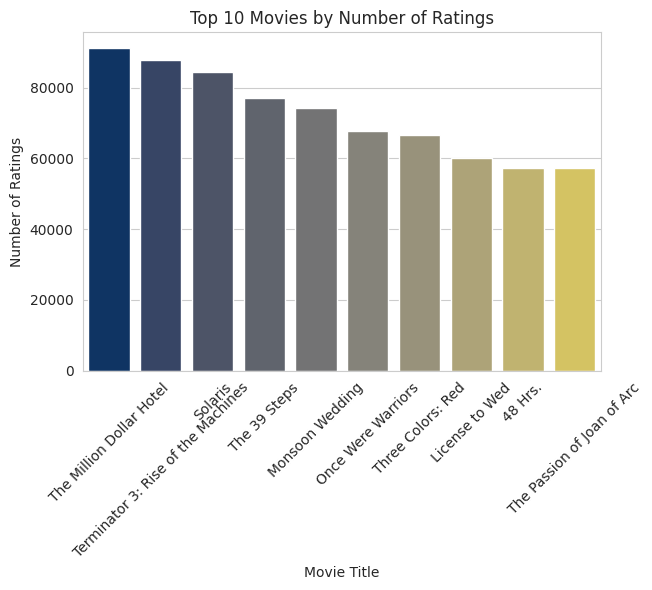

/tmp/ipython-input-3113932973.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=user_rating, palette='viridis')


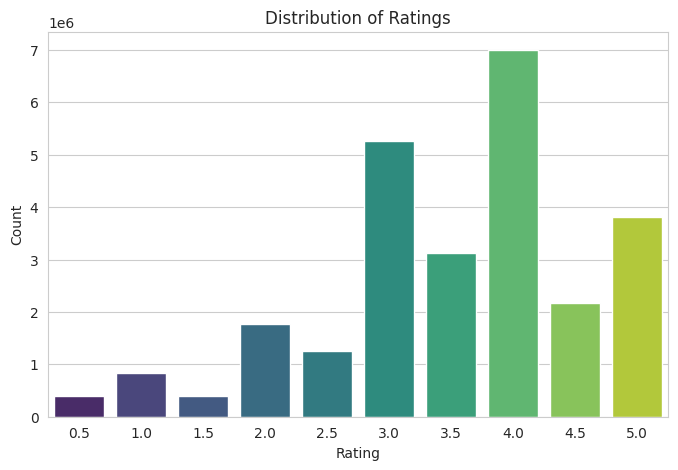

In [100]:
# @title

# -----------------------------
# 1️⃣ General Information
# -----------------------------
n_rows, n_cols = user_rating.shape
data_types = user_rating.dtypes.to_dict()

# Target variable statistics
target_var = 'rating'
rating_mean = user_rating[target_var].mean()
rating_std = user_rating[target_var].std()
rating_min = user_rating[target_var].min()
rating_max = user_rating[target_var].max()
rating_median = user_rating[target_var].median()

display(HTML(f"""
<h3>1. General Information</h3>
<p>Number of observations: {n_rows:,}</p>
<p>Number of features: {n_cols}</p>
<p>Data types: {data_types}</p>

<h4>Target Variable: {target_var}</h4>
<ul>
  <li>Mean: {rating_mean:.2f}</li>
  <li>Std Dev: {rating_std:.2f}</li>
  <li>Range: {rating_min} to {rating_max}</li>
  <li>Median: {rating_median}</li>
</ul>
"""))

# -----------------------------
# 2️⃣ Summary & Visualizations
# -----------------------------
# 2a. Missing values
missing_vals = user_rating.isna().sum()

display(HTML(f"""
<h4>Missing Values</h4>
<p>{missing_vals.to_dict()}</p>
"""))
# Merge user_rating with movies to get titles
user_rating['movieId'] = user_rating['movieId'].astype(int)
movies['movieId'] = movies['movieId'].astype(int)

ratings_with_titles = user_rating.merge(movies[['movieId', 'title']], on='movieId', how='left')

ratings_with_titles = user_rating.merge(movies[['movieId', 'title']], on='movieId', how='left')

# 2c. Top 10 Users and Top 10 Movies by number of ratings
top_users = ratings_with_titles['userId'].value_counts().head(10)
top_movies = ratings_with_titles['title'].value_counts().head(10)

plt.subplot(1,2,2)
sns.barplot(x=top_movies.index, y=top_movies.values, palette='cividis')
plt.xticks(rotation=45)
plt.title('Top 10 Movies by Number of Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()

# 2b. Rating distribution
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=user_rating, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


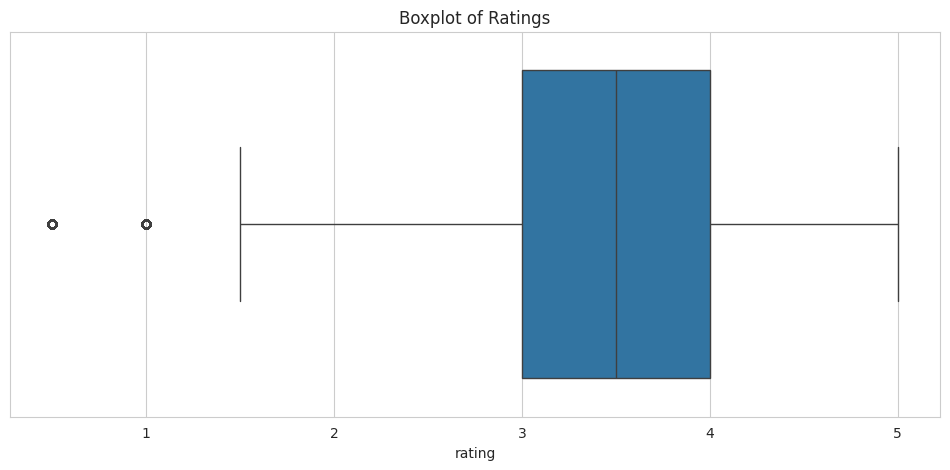

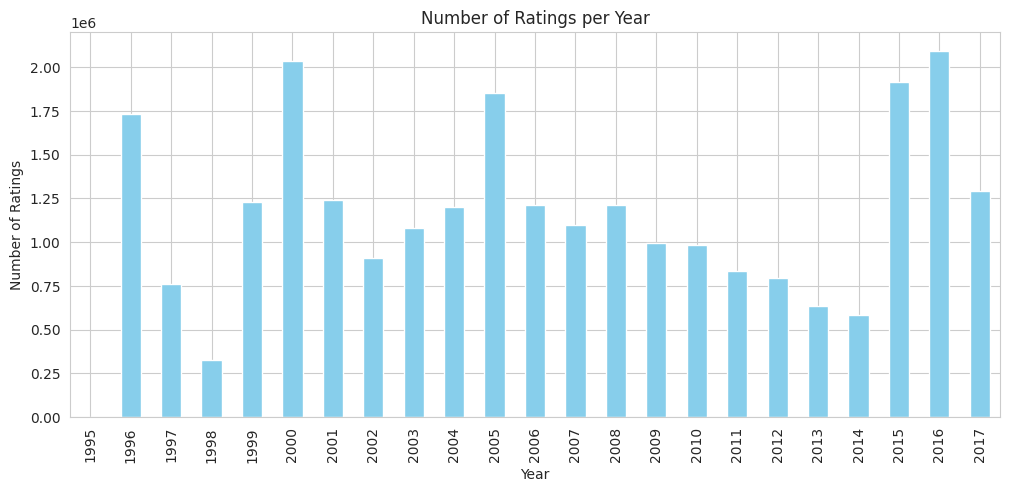

In [101]:
# @title
# 2d. Rating statistics per user / per movie
plt.figure(figsize=(12,5))
sns.boxplot(x='rating', data=user_rating)
plt.title('Boxplot of Ratings')
plt.show()

# timestamp distribution if needed
user_rating['timestamp'] = pd.to_datetime(user_rating['timestamp'], unit='s')
plt.figure(figsize=(12,5))
user_rating['timestamp'].dt.year.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

**Dropping Unnecessary Columns**

In [102]:
user_rating.drop(columns = ["timestamp"],inplace = True)

**Removing Duplicates**

In [103]:
user_rating.drop_duplicates()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0
...,...,...,...
26024284,270896,58559,5.0
26024285,270896,60069,5.0
26024286,270896,63082,4.5
26024287,270896,64957,4.5


**Checking for Null Values**

In [104]:
user_rating.isnull().sum() #Checking for Null values

,0
userId,0
movieId,0
rating,0


**Filtering Active Users**
Description / Justification:

Purpose:

These lines filter the dataset to include only “active” users, users who have rated a reasonable number of movies.

This helps to reduce noise from users who rate very few movies (sparse data) and users who rate too many movies (outliers or abnormal behavior).


The upper limit of 2,000 was determined experimentally: as we progressively increased the maximum number of ratings per user, we observed that including users beyond this threshold did not significantly add more ratings, indicating diminishing returns.
Effect:

This reduces the dataset to a subset of reliable users, improving model performance and reducing sparsity.

In [105]:
user_ratings_count = user_rating.groupby("userId")["rating"].count()
user_ratings_count[(user_ratings_count <= 2000) & (user_ratings_count >= 100)]


,rating
userId,
8,113
11,227
12,248
15,226
16,182
...,...
270879,413
270885,149
270893,190


In [106]:
max_ratings = 2000
min_ratings = 100
active_users = user_ratings_count[(user_ratings_count <= max_ratings) & (user_ratings_count >= min_ratings)].index
filtered_df = user_rating[user_rating["userId"].isin(active_users)]
print("Original size:", user_rating.shape)
print("Filtered size:", filtered_df.shape)


Original size: (26024289, 3)
Filtered size: (19047077, 3)


## **4. Merge Datasets**

### 4.1 Merging and cleaning the dataset after merge

In [107]:
merged_df = pd.merge(user_rating, movies, on="movieId", how="left")


In [108]:
merged_df.head(10)

,userId,movieId,rating,belongs_to_collection,budget,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,title,genre1,genre2,weighted_rating,release_year
0,1,110,1.0,Three Colors Collection,0.0,fr,Trois couleurs : Rouge,Red This is the third film from the trilogy by...,7.832755,Zespół Filmowy TOR,France,0.0,99.0,Three Colors: Red,Drama,Mystery,7.686409,1994.0
1,1,147,4.5,The Adventures of Antoine Doinel,0.0,fr,Les Quatre Cents Coups,"For young Parisian boy Antoine Doinel, life is...",7.268688,Les Films du Carrosse,France,0.0,99.0,The 400 Blows,Drama,Drama,7.913631,1959.0
2,1,858,5.0,NO Collection,21000000.0,en,Sleepless in Seattle,A young boy who tries to set his dad up on a d...,10.234919,TriStar Pictures,United States of America,227799884.0,105.0,Sleepless in Seattle,Comedy,Drama,6.484268,1993.0
3,1,1221,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1246,5.0,Rocky Collection,24000000.0,en,Rocky Balboa,When he loses a highly publicized virtual boxi...,11.697604,Columbia Pictures,United States of America,155721132.0,102.0,Rocky Balboa,Drama,Drama,6.488377,2006.0
5,1,1968,4.0,NO Collection,0.0,en,Fools Rush In,Alex Whitman (Matthew Perry) is a designer fro...,6.285574,Columbia Pictures,United States of America,29481428.0,109.0,Fools Rush In,Drama,Comedy,5.802383,1997.0
6,1,2762,4.5,NO Collection,0.0,en,Young and Innocent,Derrick De Marney finds himself in a 39 Steps ...,3.824884,Gaumont British Picture Corporation,United Kingdom,0.0,83.0,Young and Innocent,Drama,Crime,6.543030,1937.0
7,1,2918,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2959,4.0,NO Collection,35000000.0,en,License to Wed,"Newly engaged, Ben and Sadie can't wait to sta...",7.102076,Village Roadshow Pictures,Australia,69307224.0,91.0,License to Wed,Comedy,Comedy,5.328764,2007.0
9,1,4226,4.0,NO Collection,5000000.0,en,Shriek If You Know What I Did Last Friday the ...,Another spoof of the Scream/I Know What You Di...,3.956594,Endless Entertainment,United States of America,0.0,86.0,Shriek If You Know What I Did Last Friday the ...,Comedy,Comedy,4.980620,2000.0


In [109]:
merged_df.dropna(subset=['original_title'],inplace = True) #Removing user ratings which don't have a corresponding movie title
merged_df.head(10)

,userId,movieId,rating,belongs_to_collection,budget,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,title,genre1,genre2,weighted_rating,release_year
0,1,110,1.0,Three Colors Collection,0.0,fr,Trois couleurs : Rouge,Red This is the third film from the trilogy by...,7.832755,Zespół Filmowy TOR,France,0.0,99.0,Three Colors: Red,Drama,Mystery,7.686409,1994.0
1,1,147,4.5,The Adventures of Antoine Doinel,0.0,fr,Les Quatre Cents Coups,"For young Parisian boy Antoine Doinel, life is...",7.268688,Les Films du Carrosse,France,0.0,99.0,The 400 Blows,Drama,Drama,7.913631,1959.0
2,1,858,5.0,NO Collection,21000000.0,en,Sleepless in Seattle,A young boy who tries to set his dad up on a d...,10.234919,TriStar Pictures,United States of America,227799884.0,105.0,Sleepless in Seattle,Comedy,Drama,6.484268,1993.0
4,1,1246,5.0,Rocky Collection,24000000.0,en,Rocky Balboa,When he loses a highly publicized virtual boxi...,11.697604,Columbia Pictures,United States of America,155721132.0,102.0,Rocky Balboa,Drama,Drama,6.488377,2006.0
5,1,1968,4.0,NO Collection,0.0,en,Fools Rush In,Alex Whitman (Matthew Perry) is a designer fro...,6.285574,Columbia Pictures,United States of America,29481428.0,109.0,Fools Rush In,Drama,Comedy,5.802383,1997.0
6,1,2762,4.5,NO Collection,0.0,en,Young and Innocent,Derrick De Marney finds himself in a 39 Steps ...,3.824884,Gaumont British Picture Corporation,United Kingdom,0.0,83.0,Young and Innocent,Drama,Crime,6.543030,1937.0
8,1,2959,4.0,NO Collection,35000000.0,en,License to Wed,"Newly engaged, Ben and Sadie can't wait to sta...",7.102076,Village Roadshow Pictures,Australia,69307224.0,91.0,License to Wed,Comedy,Comedy,5.328764,2007.0
9,1,4226,4.0,NO Collection,5000000.0,en,Shriek If You Know What I Did Last Friday the ...,Another spoof of the Scream/I Know What You Di...,3.956594,Endless Entertainment,United States of America,0.0,86.0,Shriek If You Know What I Did Last Friday the ...,Comedy,Comedy,4.980620,2000.0
14,1,58559,4.0,NO Collection,0.0,fr,Confession of a Child of the Century,"Paris, 1830: Octave, betrayed by his mistress,...",0.778480,Les Films du Veyrier,France,0.0,120.0,Confession of a Child of the Century,Drama,Drama,5.559652,2012.0
23,1,96821,5.0,NO Collection,0.0,it,Cesare deve morire,Winner of the Golden Bear at the 2012 Berlin F...,9.737921,Kaos Cinematografica,Italy,0.0,76.0,Caesar Must Die,Drama,Documentary,6.335289,2012.0


In [110]:
merged_df.isnull().sum() #Check for null values in the new dataset after merging

,0
userId,0
movieId,0
rating,0
belongs_to_collection,0
budget,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0


### 4.2 General Information after Merge

In [111]:
# @title
from IPython.display import display, HTML

# General Info
n_rows, n_cols = merged_df.shape

# Data types in readable format
dtypes_readable = {
    'Integer': [col for col in merged_df.columns if merged_df[col].dtype in ['int64', 'int32']],
    'Float': [col for col in merged_df.columns if merged_df[col].dtype in ['float64', 'float32']],
    'Object / String': [col for col in merged_df.columns if merged_df[col].dtype == 'object']
}

# Missing values
missing_vals = merged_df.isna().sum()
missing_info = {col: cnt for col, cnt in missing_vals.items() if cnt > 0}

display(HTML(f"""
<h3>General Information - Merged Dataset</h3>
<p><b>Number of observations:</b> {n_rows:,}</p>
<p><b>Number of features:</b> {n_cols}</p>

<h4>Data Types</h4>
<ul>
  <li><b>Integer:</b> {', '.join(dtypes_readable['Integer'])}</li>
  <li><b>Float:</b> {', '.join(dtypes_readable['Float'])}</li>
  <li><b>Object / String:</b> {', '.join(dtypes_readable['Object / String'])}</li>
</ul>

<h4>Missing Values</h4>
<p>{missing_info if missing_info else "No missing values"}</p>
"""))


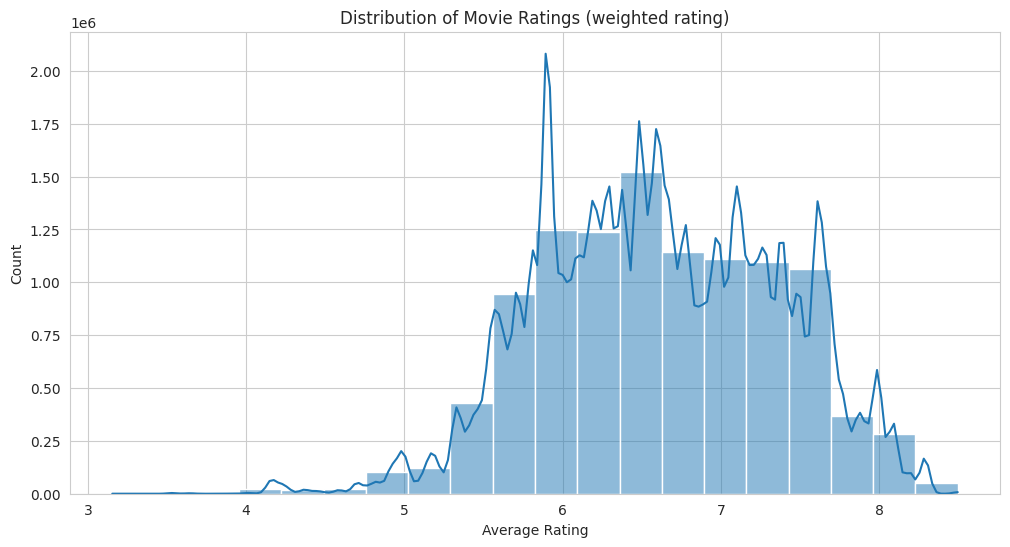

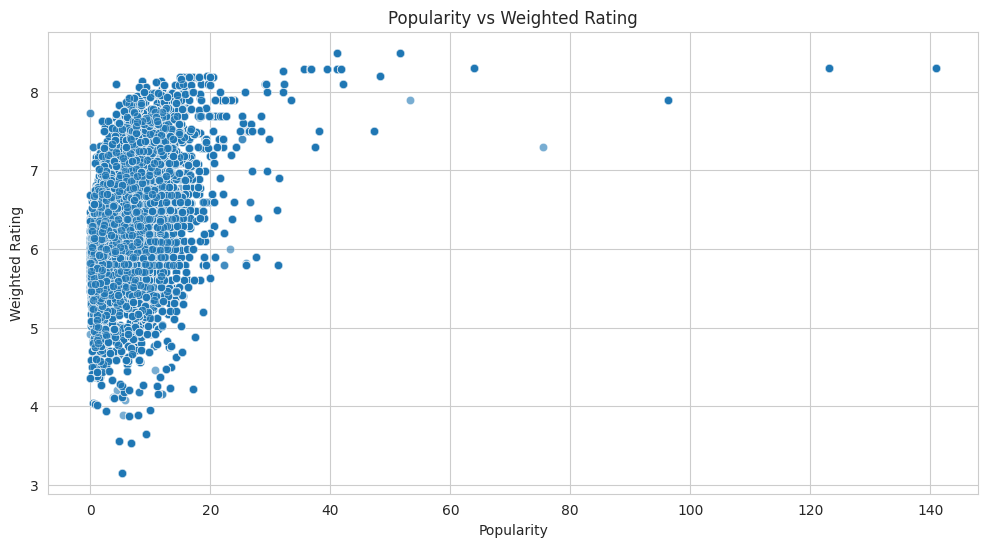

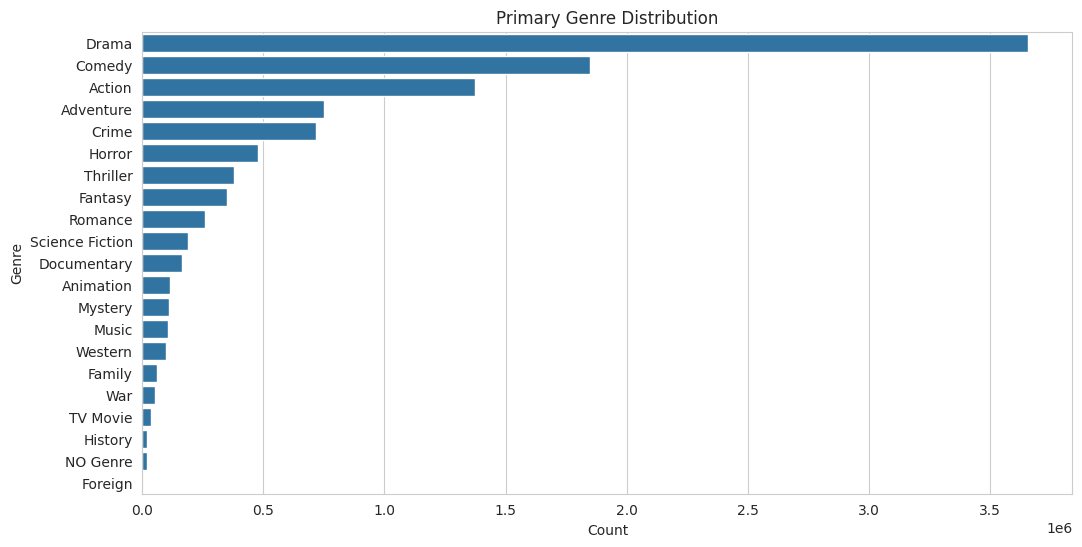

/tmp/ipython-input-3747611977.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_popularity, y="genre1", x="popularity", palette="viridis")


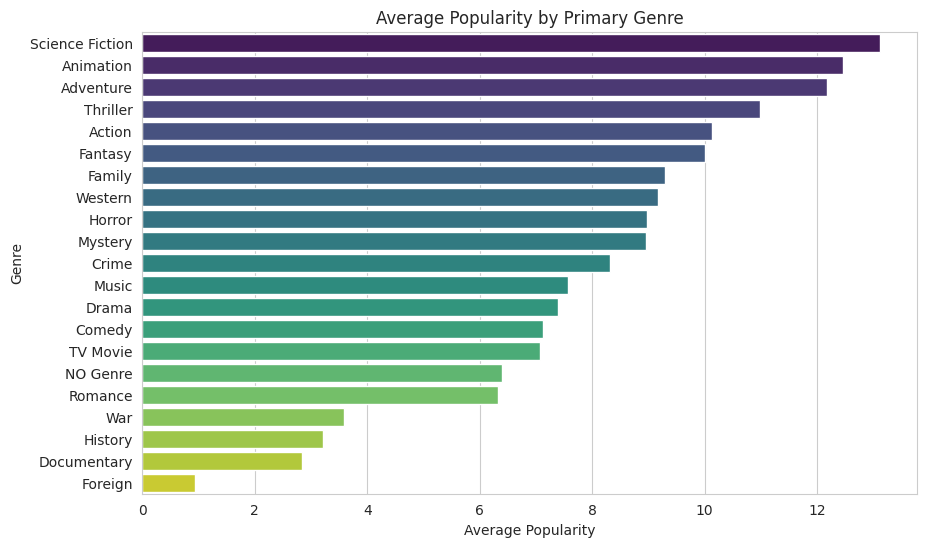

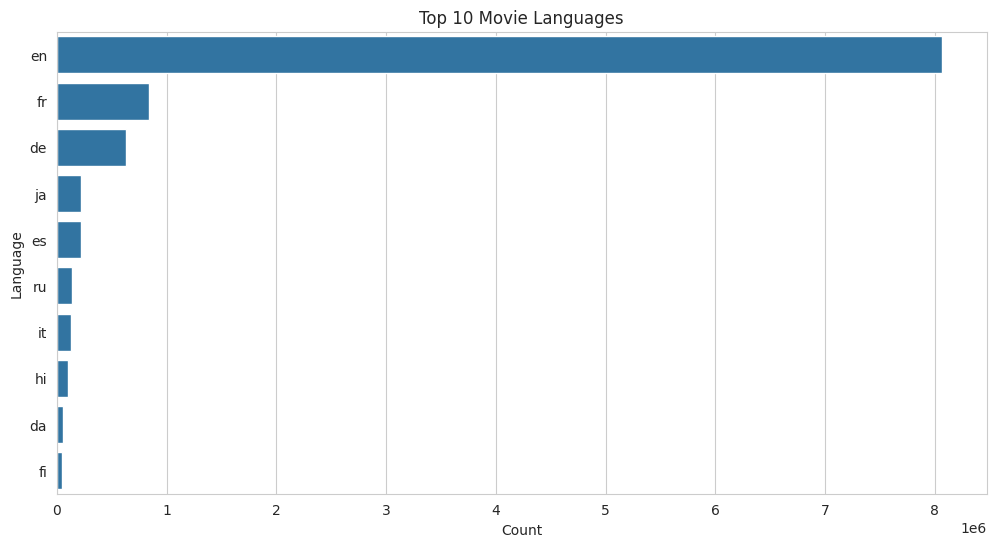

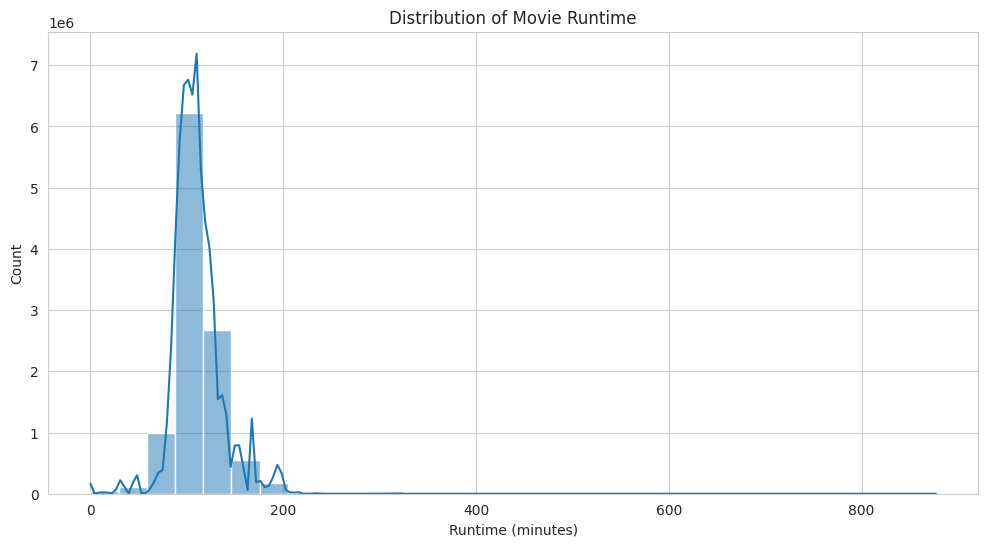

In [112]:
# @title

# --- 1. RATINGS AND POPULARITY INSIGHTS ---
plt.figure()
sns.histplot(merged_df["weighted_rating"], bins=20, kde=True)
plt.title("Distribution of Movie Ratings (weighted rating)")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()


plt.figure()
sns.scatterplot(data=merged_df, x="popularity", y="weighted_rating", alpha=0.6)
plt.title("Popularity vs Weighted Rating")
plt.xlabel("Popularity")
plt.ylabel("Weighted Rating")
plt.show()

# --- 3. GENRE ANALYSIS ---
plt.figure()
sns.countplot(y="genre1", data=merged_df, order=merged_df["genre1"].value_counts().index)
plt.title("Primary Genre Distribution")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


avg_popularity = merged_df.groupby("genre1")["popularity"].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=avg_popularity, y="genre1", x="popularity", palette="viridis")
plt.title("Average Popularity by Primary Genre")
plt.xlabel("Average Popularity")
plt.ylabel("Genre")
plt.show()

# --- 4. LANGUAGE AND COUNTRY INSIGHTS ---
plt.figure()
sns.countplot(y="original_language", data=merged_df, order=merged_df["original_language"].value_counts().index[:10])
plt.title("Top 10 Movie Languages")
plt.xlabel("Count")
plt.ylabel("Language")
plt.show()


# --- 5. RUNTIME DISTRIBUTION ---
plt.figure()
sns.histplot(merged_df["runtime"], bins=30, kde=True)
plt.title("Distribution of Movie Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Count")
plt.show()


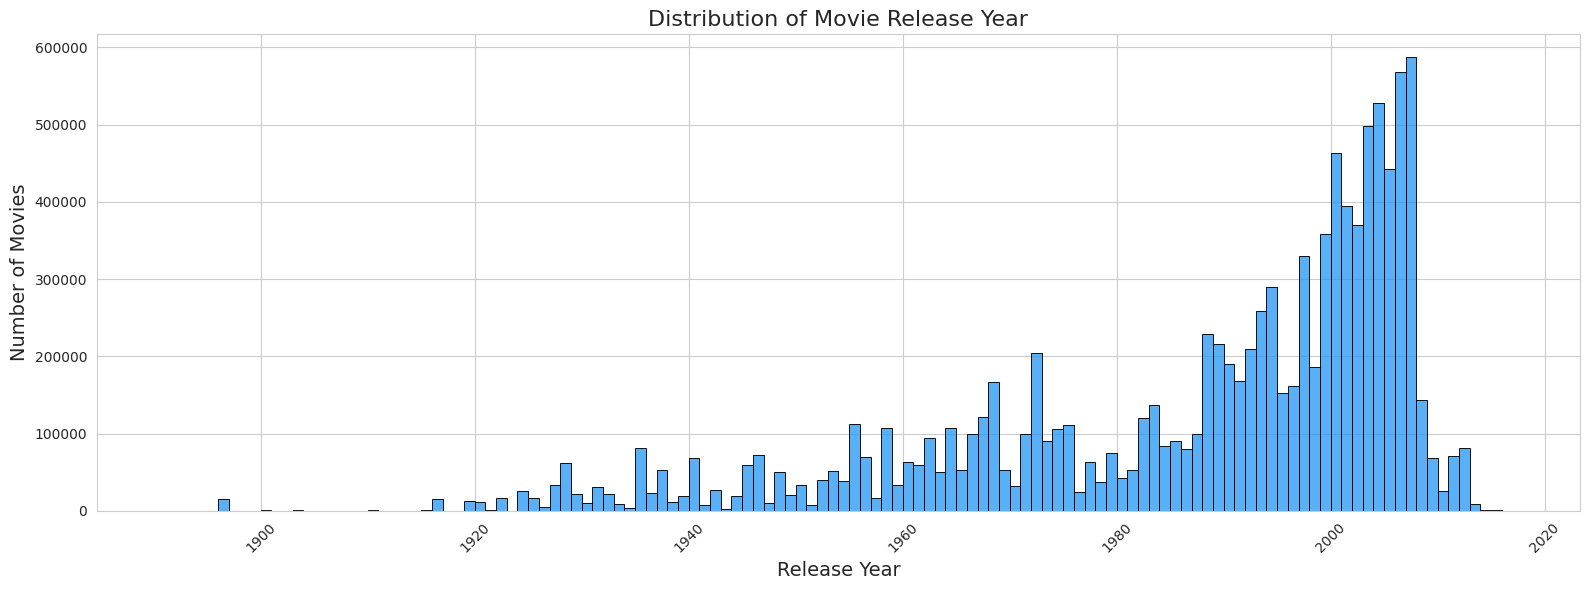

In [113]:
# @title
# Convert release_year to integer safely
merged_df['release_year'] = merged_df['release_year'].dropna().astype(int)


plt.figure(figsize=(16,6))
sns.histplot(merged_df['release_year'],
             bins=range(merged_df['release_year'].min(), merged_df['release_year'].max() + 1),
             color='#2196F3', edgecolor='black')
plt.title('Distribution of Movie Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Data Encoding
*a. Feature Preprocessing and Engineering*

In this section, we prepare the merged dataset for machine learning by transforming all relevant features into numerical representations that can be fed into a model. The preprocessing pipeline handles categorical variables, numerical variables, and text data in a systematic way.

*b. Categorical Feature Encoding:*

All categorical columns (except userId, movieId, and overview) are transformed into numeric labels using a label encoding approach.

This allows machine learning algorithms to interpret categorical information as discrete numerical values while preserving the distinct categories.

The encoders are stored in a dictionary, which can be reused later to transform new data consistently.

*c. Numerical Feature Scaling:*

Continuous numerical features are standardized using a scaling technique that centers values around zero with unit variance.

This ensures that features with larger numeric ranges do not dominate those with smaller ranges during model training.

userId and movieId are excluded because they are identifiers, not predictive features.

*d. Text Feature Transformation (TF-IDF):*

The textual overview column is converted into a numeric representation using TF-IDF vectorization.

This captures the importance of words relative to all movie overviews, producing a dense feature matrix that reflects semantic content.

Limiting the maximum number of features helps manage dimensionality and improves computational efficiency.

*e. Combining Features:*

The processed numerical and categorical features are combined with the TF-IDF representation of the text to create a single feature matrix suitable for machine learning.

This unified matrix (X) includes all relevant information from the original dataset while keeping identifiers separate for potential use in recommendation logic.

Overall, this preprocessing pipeline ensures that the dataset is clean, fully numeric, and standardized, while capturing both structured (categorical and numerical) and unstructured (text) information. This prepares the data for any downstream machine learning task, such as content-based recommendation, regression, or classification.

In [114]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Fill missing overview text
merged_df['overview'] = merged_df['overview'].fillna('')

# -------------------------------
# 1️⃣ Encode categorical columns
# -------------------------------
label_cols = [col for col in merged_df.columns
              if merged_df[col].dtype == 'object' and col not in ['userId', 'movieId', 'overview']]
print("Label Encoding Columns:", label_cols)

encoders = {}
for col in label_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    encoders[col] = le

# -------------------------------
# 2️⃣ Scale numerical columns (exclude IDs)
# -------------------------------
num_cols = [col for col in merged_df.columns
            if merged_df[col].dtype != 'object' and col not in ['userId', 'movieId']]
print("Numerical Columns for Scaling:", num_cols)

scaler = StandardScaler()
merged_df[num_cols] = scaler.fit_transform(merged_df[num_cols])

# -------------------------------
# 3️⃣ TF-IDF for 'overview'
# -------------------------------
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
overview_features = tfidf.fit_transform(merged_df['overview'])

# -------------------------------
# 4️⃣ Combine all features
# -------------------------------
# Select the numerical + categorical features (excluding overview)
other_features = merged_df.drop(columns=['overview', 'userId', 'movieId'])
X = hstack([other_features.values, overview_features])

print("Final feature shape:", X.shape)

Label Encoding Columns: ['belongs_to_collection', 'original_language', 'original_title', 'production_companies', 'production_countries', 'title', 'genre1', 'genre2']
Numerical Columns for Scaling: ['rating', 'belongs_to_collection', 'budget', 'original_language', 'original_title', 'popularity', 'production_companies', 'production_countries', 'revenue', 'runtime', 'title', 'genre1', 'genre2', 'weighted_rating', 'release_year']
Final feature shape: (10778474, 5015)


In [115]:
merged_df.head()

,userId,movieId,rating,belongs_to_collection,budget,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,title,genre1,genre2,weighted_rating,release_year
0,1,110,-2.371896,2.823220,-0.540509,0.451738,1.394703,Red This is the third film from the trilogy by...,-0.093751,1.407163,-1.346095,-0.442151,-0.447079,1.465528,0.071574,0.835476,1.438220,0.326009
1,1,147,0.905790,1.455228,-0.540509,0.451738,-0.148613,"For young Parisian boy Antoine Doinel, life is...",-0.179879,-0.163664,-1.346095,-0.442151,-0.447079,0.713503,0.071574,-0.395375,1.742190,-1.310337
2,1,858,1.374031,-0.016009,0.003514,-0.286776,0.620890,A young boy who tries to set his dad up on a d...,0.273036,1.139100,0.729899,0.830824,-0.198304,0.544830,-0.565138,-0.395375,-0.169959,0.279256
4,1,1246,1.374031,0.655082,0.081231,-0.286776,0.466990,When he loses a highly publicized virtual boxi...,0.496373,-1.254048,0.729899,0.428039,-0.322691,0.377374,0.071574,-0.395375,-0.164462,0.887042
5,1,1968,0.437549,-0.016009,-0.540509,-0.286776,-0.762369,Alex Whitman (Matthew Perry) is a designer fro...,-0.329991,-1.254048,0.729899,-0.277405,-0.032453,-0.758276,0.071574,-0.922882,-1.082159,0.466267


## **6. Summary**

The movies dataset contains a mix of numerical, categorical, and text features describing movies (e.g., budget, revenue, genres, overview, title).

The user ratings dataset provides user-specific ratings for movies over time.

EDA revealed:

A small number of adult movies can be removed to avoid outliers.

Many features have missing values that need preprocessing (e.g., overview, belongs_to_collection).

Popularity, revenue, and vote-related features vary widely and require scaling.

Feature engineering applied:

Weighted rating computed to account for both vote count and vote average.

Categorical features encoded using one-hot or frequency encoding.

Textual features (overview, title) transformed into TF-IDF embeddings.

The final dataset is ready for clustering, regression, or recommendation modeling, with sparse TF-IDF matrices stored separately to save memory.